In [21]:
# ───────────────────── 0. Imports ─────────────────────────
import os, json, time, warnings, pandas as pd
from pathlib import Path
warnings.filterwarnings("ignore")

from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv

# -----------------------------------------------------------------
load_dotenv() 

API_KEY = os.getenv("OPENAI_API_KEY")
LLM_NAME = "gpt-4o-mini"              
llm = ChatOpenAI(model_name=LLM_NAME, temperature=0.0)

In [22]:
# %% ───────────────────── 1. Load text samples from Part 2 ─────
df = pd.read_csv("../results/whisper_transcripts.csv")   # cols: filename, transcribed_text, emotion
texts = df["transcribed_text"].tolist()

In [ ]:
# ───────────────────── 2. Prompt template ──────────────────
PROMPT = """
You are a precise sentiment classifier.

Return **only** a valid JSON object with two keys:
  "sentiment": _exactly one of_ [`positive`, `negative`, `neutral`]
  "emotion"  : _exactly one of_ [`joy`, `sadness`, `anger`,
                                 `fear`, `surprise`, `disgust`, `neutral`]

Do **not** output anything except the JSON.

Text: {text}
JSON:
"""

template = PromptTemplate.from_template(PROMPT)


# helper that retries on rate-limit
def call_llm(text):
    msg = HumanMessage(content=template.format(text=text))
    for _ in range(3):
        try:
            resp = llm([msg]).content
            return resp
        except Exception as e:
            time.sleep(2)
    raise RuntimeError("LLM failed 3×")

In [26]:
# ───────────────────── 3. Batch inference (cached) ─────────
CACHE = Path("../results/llm_outputs.json")
if CACHE.exists():
    outputs = json.load(CACHE.open())
else:
    outputs = [call_llm(t) for t in texts]
    json.dump(outputs, CACHE.open("w"))

def parse_out(s):
    try:
        obj = json.loads(s)
        return obj["emotion"]
    except Exception:
        return "parse_error"

df["llm_emotion"] = [parse_out(o) for o in outputs]

LLM macro-F1: 0.104


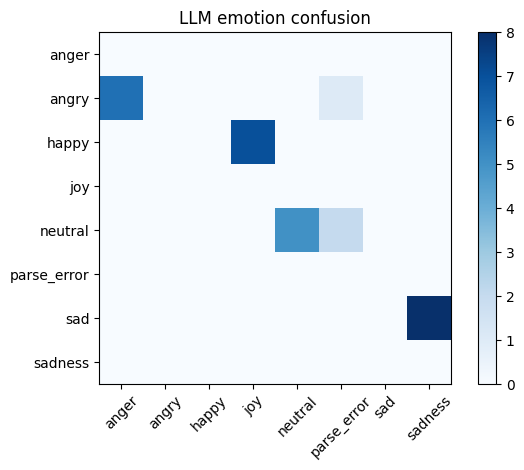

In [28]:
# %% ───────────────────── 4. Evaluation ───────────────────────
y_true = df["emotion"]
y_pred = df["llm_emotion"]

macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
print("LLM macro-F1:", round(macro, 3))

labels = sorted(set(y_true) | set(y_pred))
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.title("LLM emotion confusion"); plt.tight_layout(); plt.show()

# save for report
df.to_csv("../results/llm_metrics.csv", index=False)

In [29]:
# s───────────────────── 5. Cost estimate ─────────────────────
TOKENS_PER_REQUEST = 300     # rough average after prompt + completion
PRICE_PER_1K = 0.0005        # $/1k tokens for gpt-4o-mini (check dashboard!)
cost = TOKENS_PER_REQUEST * len(df) * PRICE_PER_1K / 1000
print(f"Estimated cost: ${cost:.4f}")
with open("../results/cost_estimate.txt","w") as f:
    f.write(f"{cost:.4f}")

Estimated cost: $0.0044
